Indentitas
Sebastian Willys Lambang/200710639

SQLAlchemy_KlasifikasiJamurEnokiKancingKuping_MobileNet

In [1]:
#Import library
import os
import numpy as np

#Import library tensorflow dan modul keras yang diperlukan
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten



In [3]:
import os

count = 0 
dirs = os.listdir(r'train_data')
for dir in dirs:
    folder_path = os.path.join('train_data', dir)
    if os.path.isdir(folder_path):
        files = os.listdir(folder_path)
        print(f"{dir} Folder has {len(files)} Images")
        count += len(files)  
print(f"Images Folder has {count} Images")


JamurEnoki Folder has 100 Images
JamurKancing Folder has 100 Images
JamurKuping Folder has 100 Images
Images Folder has 300 Images


In [4]:
base_dir = r'train_data' 
img_size = 180 
batch = 32 
validation_split = 0.1

In [5]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
)

Found 300 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['JamurEnoki', 'JamurKancing', 'JamurKuping']


In [7]:
total_count = len(dataset)
val_count = int(total_count * validation_split)
train_count = total_count - val_count

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)

Total Images: 10
Train Images: 9
Validation Images: 1


In [8]:
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

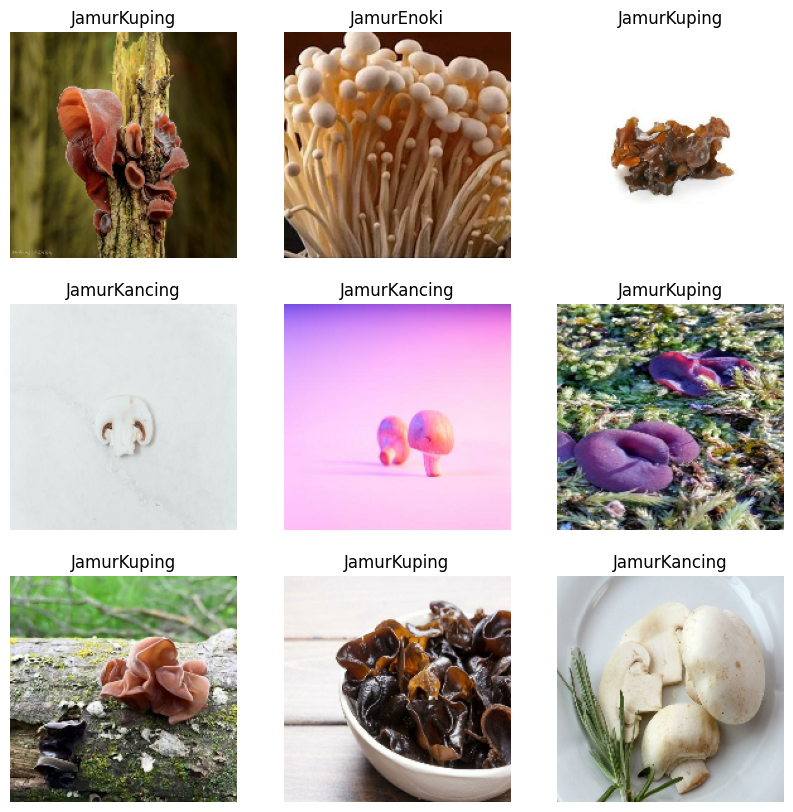

In [9]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1): 
    for i in range(9):
        plt.subplot(3,3, i+1) 
        plt.imshow(images[i].numpy().astype('uint8')) 
        plt.title(class_names[labels[i]]) 
        plt.axis('off') 

In [10]:
import numpy as np

for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)

(32, 180, 180, 3)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [13]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [14]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

c:\Python39\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


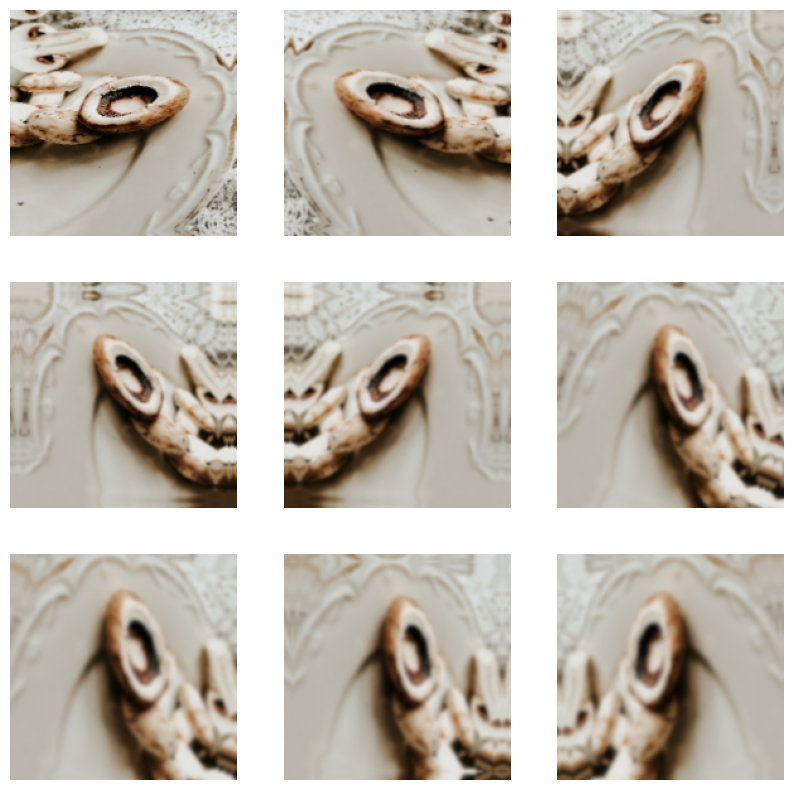

In [15]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [16]:
from tensorflow.keras.applications import MobileNet 
from tensorflow.keras.models import Model


base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))

base_model.trainable = True 
fine_tune_at = len(base_model.layers) // 2  
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False 

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
    
    ])


C:\Users\Antonius Rio\AppData\Local\Temp\ipykernel_18412\99726284.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))


In [17]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 5, 5, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,451 (12.82 MB)

 Trainable params: 3,069,443 (11.71 MB)

 Non-trainable params: 291,008 (1.11 MB)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',
                              patience=3,
                              mode='max')

history= model.fit(train_ds,
                   epochs=30, 
                   validation_data=val_ds, 
                   callbacks=[early_stopping])

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5685 - loss: 1.0810 - val_accuracy: 0.5833 - val_loss: 0.9887
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9449 - loss: 0.1882 - val_accuracy: 0.7500 - val_loss: 0.5603
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9860 - loss: 0.0619 - val_accuracy: 0.7500 - val_loss: 0.3909
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9901 - loss: 0.0296 - val_accuracy: 0.9167 - val_loss: 0.2183
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 987ms/step - accuracy: 1.0000 - loss: 0.0200 - val_accuracy: 1.0000 - val_loss: 0.1104
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9908 - loss: 0.0217 - val_accuracy: 1.0000 - val_loss: 0.0543
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9939 - loss: 0.0225 - val_accuracy: 1.0000 - val_loss: 0.0379
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 0.0271


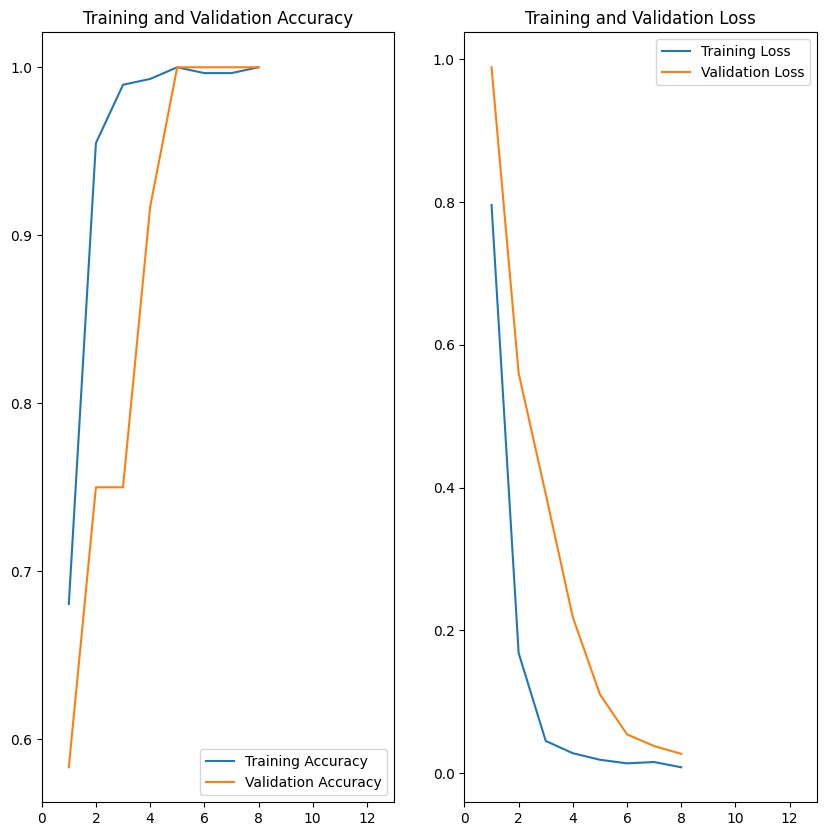

In [20]:
ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlim(0, 13)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

In [25]:
model.save('BestModel_MobileNet_SQLAlchemy.h5')

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

model = load_model(r'BestModel_MobileNet_SQLAlchemy.h5')
class_names = ['JamurEnoki', 'JamurKancing', 'JamurKuping']

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0) 

        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0]) 
        class_idx = np.argmax(result) 
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path) 
        input_image.save(save_path) 

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

result = classify_images(r'test_data/JamurKancing/JamurKancingTest_01.jpg', save_path='JamurKancing.jpg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
Prediksi: JamurKancing
Confidence: 57.61%
Prediksi: JamurKancing dengan confidence 57.61%. Gambar asli disimpan di JamurKancing.jpg.


Found 30 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


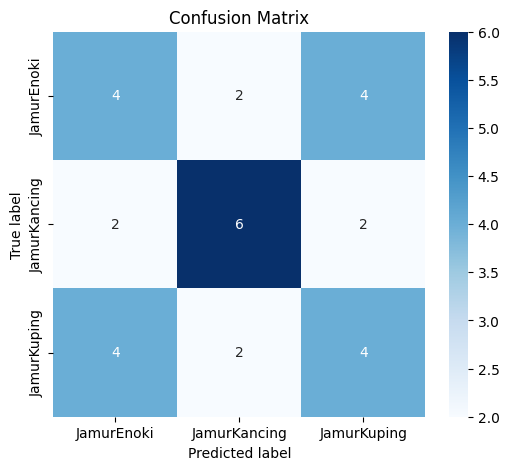

Confusion Matrix:
 [[4 2 4]
 [2 6 2]
 [4 2 4]]
Akurasi: 0.4666666666666667
Presisi: [0.4 0.6 0.4]
Recall: [0.4 0.6 0.4]
F1 Score: [0.4 0.6 0.4]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

mobileNet_model = load_model(r'BestModel_MobileNet_SQLAlchemy.h5')

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data', 
    labels='inferred', 
    label_mode='categorical', 
    batch_size=32, 
    image_size=(180, 180)
)

y_pred = mobileNet_model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)  

true_labels = [] 
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
true_labels = tf.convert_to_tensor(true_labels) 

conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

f1_score = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=["JamurEnoki", "JamurKancing", "JamurKuping"], yticklabels=["JamurEnoki", "JamurKancing", "JamurKuping"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())
